In [1]:
import tkinter as tk
from scipy.stats import norm
from PIL import ImageTk 
from PIL import Image 
import os
import imageio
import numpy as np
import math
    
path = 'LFdata/toyLF/'
Temp = [] 
for i in range(1,257):
    if i<10:
        name = "00"+str(i)
    elif i<100:
        name = "0"+str(i)
    else:
        name = str(i)
    Temp.append(imageio.imread(os.path.join(path,'lowtoys'+name+'.bmp')))

def matrix_2_img(matrix):
    return matrix.reshape(240,320,3)
def img_2_matrix(img):
    return img.reshape(320*240,3)
Data = []
for i in range(len(Temp)):
    Data.append(img_2_matrix(Temp[i]))
Data = np.array(Data)

In [25]:
Data_cut = []
for i in range(len(Data)):
    if i%4 == 0:
        Data_cut.append(Data[i])

In [26]:
len(Data_cut)

64

In [3]:
root = tk.Tk()

def Get_image(self):
    print(Y.get())

root.title("Assignment1")
imgtk = ImageTk.PhotoImage(image=Image.fromarray(matrix_2_img(Data[0])))
Y = tk.Scale(root, from_=16, to=0 ,length=240,resolution=0.1,\
             orient="vertical",label="Y",command = Get_image)
Y.grid(column = 1, row = 1)

W = tk.Label(root,image = imgtk,height = 240,width = 320)
W.grid(column = 2, row = 1)

X = tk.Scale(root, from_=0, to=16, length=320, \
      resolution=0.1,orient="horizontal",label = "X").grid(column = 2, row = 2)
Z = tk.Scale(root, from_=1, to=0, length=320, \
      resolution=0.05,orient="horizontal",label = "Z").grid(column = 2, row = 3)
D_x = tk.Scale(root, from_=0, to=5, length=200, \
      resolution=0.1,orient="vertical",label = "D_x").grid(column = 3, row = 1)
D_y = tk.Scale(root, from_=0, to=5, length=200, \
      resolution=0.1,orient="vertical",label = "D_y").grid(column = 4, row = 1)
Aperture_size = tk.Scale(root, from_=1, to=10, length=200, \
      resolution=0.1,orient="vertical",label = "Aperture_size").grid(column = 5, row = 1)
var1 = tk.IntVar()
var2 = tk.IntVar()
If_aperture = tk.Checkbutton(root, text="Aperture Model", variable=var1).grid(column=3,row = 2)
If_pinhole = tk.Checkbutton(root, text="Pinhole Model", variable=var2).grid(column =3, row=3)

Make = tk.Button(root,text="Make image").grid(column = 5,row = 3)
root.mainloop()

In [4]:
def normalize(v):
    norm=np.linalg.norm(v, ord=1)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm
def show_img(img):
    im=Image.fromarray(img) 
    im.show()
#get the photo [320*240] as a vector with the uv coord(x,y)
def get_photo(x,y):
    index = 255-x-16*y
    return Data[index]
#Input:photos like as(wh,3)*n,and the weight
#Output:photos*weight
def Blend_by_weight(P,w):
    Image = np.zeros((76800,3),dtype=np.uint8)
    for i in range(len(P)):
        Temp = (np.floor(P[i]*w[i])).astype(np.uint8)
        Image = Image + Temp
    return matrix_2_img(Image)

In [5]:
#x(0,15),y(0,15)
def Q_interpolator(coords):
    x,y = (coords[0],coords[1])
    x_ = int(x)
    y_ = math.ceil(y)
    d1 = x-x_
    d2 = y_-y
    w = [(1-d1)*(1-d2),d1*(1-d2),(1-d1)*d2,d1*d2]
    p1 = get_photo(x_,y_)
    p2 = get_photo(x_+1,y_)
    p3 = get_photo(x_,y_-1)
    p4 = get_photo(x_+1,y_-1)
    return Blend_by_weight([p1,p2,p3,p4],normalize(w))

In [4]:
I = Q_interpolator([8.4,8.6])

In [28]:
def get_photo_cut(x,y):
    index = 64-x-8*y
    return Data_cut[index]
#x(0,15),y(0,15)
def Q_interpolator_cut(coords):
    x,y = (coords[0],coords[1])
    x_ = int(x)
    y_ = math.ceil(y)
    d1 = x-x_
    d2 = y_-y
    w = [(1-d1)*(1-d2),d1*(1-d2),(1-d1)*d2,d1*d2]
    p1 = get_photo_cut(x_,y_)
    p2 = get_photo_cut(x_+1,y_)
    p3 = get_photo_cut(x_,y_-1)
    p4 = get_photo_cut(x_+1,y_-1)
    return Blend_by_weight([p1,p2,p3,p4],normalize(w))
cut = Q_interpolator_cut([4.5,4.5])

In [40]:
cut = Q_interpolator_cut([4.5,4.5])

In [5]:
base = Image.fromarray(I)

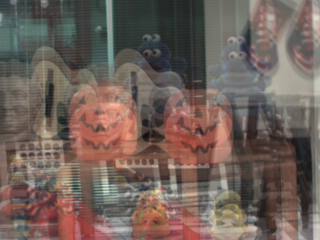

In [41]:
Image.fromarray(cut)

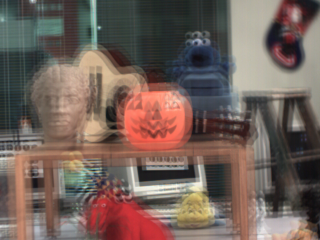

In [6]:
base

In [43]:
def disparity_matrix(disparity,h,w):
    #(u,v) = (u_,v_) + disparity(bias_x,bias_y)
    x_bias,y_bias = disparity
    White_image = np.zeros((h,w,2),dtype=np.uint16)
    for x in range(w):
        for y in range(h):
            Coord = np.array([x,y])+disparity
            if Coord[1]<0 :
                Coord[1] = 0
            if Coord[0]<0:
                Coord[0] = 0
            if Coord[1]>h-1 :
                Coord[1] = h-1
            if Coord[0]>w-1:
                Coord[0] = w-1
            White_image[y][x] = np.floor(Coord)
    return White_image

In [44]:
#repreduce the image by adjust(u,v) to new (u,v)
def re_image(Matrix,Bias_map,w,h):
    #Image base
    Image = matrix_2_img(Matrix)
    #New image
    White_image = np.zeros((h,w,3),dtype=np.uint8)
    #Based on the new,coords,get the pixels from the orginal photo
    for x in range(w):
        for y in range(h):
            u,v = Bias_map[y][x]
            White_image[y][x] = Image[v][u]
    return White_image

In [45]:
def get_bias(center,point_set,x_bias,y_bias):
    #Based on the center get the bias of all arround points
    Bias_all = [] 
    for i in range(len(point_set)):
        Bias = (np.array(point_set[i])-center)*[x_bias,y_bias]
        Bias_all.append(Bias)
    return Bias_all

In [46]:
def Q_interpolator2(coords,x_bias,y_bias):
    x,y = (coords[0],coords[1])
    x_ = int(x)
    y_ = math.ceil(y)
    Square = [[x_,y_],[x_+1,y_],[x_,y_-1],[x_+1,y_-1]]
    Bias_all = get_bias(coords,Square,x_bias,y_bias)
    #The bais for 4 photo
    d1 = x-x_
    d2 = y_-y
    w = [(1-d1)*(1-d2),d1*(1-d2),(1-d1)*d2,d1*d2]
    P = [get_photo(Square[i][0],Square[i][1]) for i in range(len(Square))]
    #All bias matrix
    Disparity_matrix = [disparity_matrix(B,240,320) for B in Bias_all]
    #All redo image
    Re_images = [re_image(P[i],Disparity_matrix[i],320,240) for i in range(len(Bias_all))]
    #Blend redo image
    R = [img_2_matrix(pp) for pp in Re_images]
    return Blend_by_weight(R,normalize(w))

In [47]:
def normalize(v):
    norm=np.linalg.norm(v, ord=1)
    if norm==0:
        norm=np.finfo(v.dtype).eps
    return v/norm

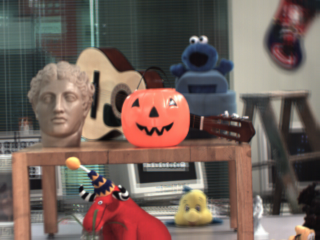

In [79]:
X = Q_interpolator2([8.4,8.6],-8.3,8.6)
im=Image.fromarray(X)
im

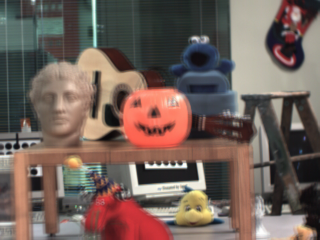

In [78]:
X = Q_interpolator2([8.4,8.6],-3.6,6.5)
im=Image.fromarray(X)
im

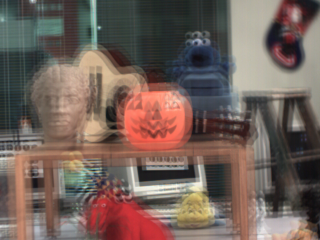

In [15]:
Y = Q_interpolator([8.4,8.6])
im=Image.fromarray(Y)
im

In [16]:
def aperture_size(coord,r):
    Max = np.array(coord)+r
    Min = np.array(coord)-r
    return print(Max)

In [73]:
aperture_size([0.5,0.5],2)

[2.5 2.5]


In [17]:
def scale_by_z(Z_,image):
    W = 320
    H = 240
    Range = np.array([0.5-Z_/2,0.5+Z_/2])
    y = (H*Range).astype(int) 
    x = (W*Range).astype(int) 
    image = image[y[0]:y[1],x[0]:x[1]]
    I = Image.fromarray(image).resize((320,240))
    return np.array(I)

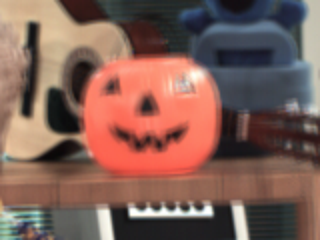

In [18]:
k = scale_by_z(0.5,X)
Image.fromarray(k)

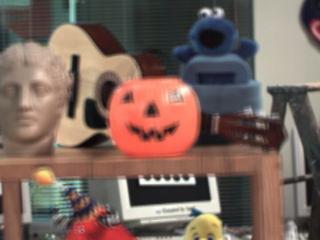

In [19]:
k = scale_by_z(0.75,X)
Image.fromarray(k)

In [80]:
#Input the Coord of the adperture,get arround
def Get_arround_set(Coord,r):
    #In circle
    Inner = []
    #Out of circle
    Outer = []
    x,y = Coord
    x1y1 = [math.floor(x-r),math.ceil(y+r)]
    x4y4 = [math.ceil(x+r),math.floor(y-r)]
    Up = [[i,x1y1[1]] for i in range(x1y1[0],x4y4[0]+1)]
    Down =  [[i,x4y4[1]] for i in range(x1y1[0],x4y4[0]+1)]
    Left = [[x1y1[0],i+1] for i in range(x4y4[1],x1y1[1]-1)]
    Right = [[x4y4[0],i+1] for i in range(x4y4[1],x1y1[1]-1)]
    Outer = Up+Down+Left+Right
    for i in range(x1y1[0]+1,x4y4[0]):
        Temp =[]
        for j in range(x4y4[1]+1,x1y1[1]):
            Temp.append([i,j])
        Inner = Inner + Temp
    return Inner,Outer

In [81]:
def Get_distence(A,center):
    A = np.array(A)
    return (np.sum((A-center)**2,axis=1))**0.5

In [82]:
#get weight
def make_weight(In_d,Out_d,r):
    #(D-r)/D
    Out_ = (Out_d-r)/Out_d
    Weight_Out = (norm.pdf(Out_d,scale=2))*Out_
    Weight_inner = norm.pdf(In_d,scale=2)
    ALL_weight = np.hstack((Weight_Out,Weight_inner))
    return ALL_weight

In [83]:
def get_aperture_image(x,y,size):
    #Get the points
    center = [x,y]
    A,B = Get_arround_set([x,y],size)
    Inner_distence = Get_distence(A,center)
    Outer_distence = Get_distence(B,center)
    Weight = make_weight(Inner_distence,Outer_distence,size)
    ALL_set = A+B
    P = [get_photo(i[0],i[1]) for i in ALL_set]
    return Blend_by_weight(P,Weight)

In [192]:
import random
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import axes
from matplotlib.font_manager import FontProperties
 
def draw(title,ALL_set,ALL_weight,size,loc):
    data = np.zeros((size,size))
    for i in range(len(ALL_set)):
        data[ALL_set[i][0]][ALL_set[i][1]]= ALL_weight[i]
    xLabel = [str(i+loc-1) for i in range(size)]
    xLabel.reverse()
    yLabel = [str(i+loc) for i in range(size)]
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.set_yticks(range(len(yLabel)))
    ax.set_yticklabels(yLabel)
    ax.set_xticks(range(len(xLabel)))
    ax.set_xticklabels(xLabel)
    im = ax.imshow(data, cmap=plt.cm.hot_r)
    plt.colorbar(im)
    plt.title(title)
    #show
    plt.show()

In [268]:
x = 8.4
y = 8.6
size = 4
#Get the points
center = [x,y]
A,B = Get_arround_set([x,y],size)
Inner_distence = Get_distence(A,center)
Outer_distence = Get_distence(B,center)

In [324]:
#A keep 1
#B keep r/d
Out_= size/Outer_distence
Inner_ = Inner_distence/Inner_distence
Weight_Out = norm.pdf(Outer_distence,scale=size*3)
Weight_inner = norm.pdf(Inner_distence,scale=size*3)
ALL_weight = np.hstack((Weight_Out,Weight_inner))

In [283]:
SS = np.hstack((Inner_*Weight_inner,Out_*Weight_Out))

In [284]:
SS = np.hstack((Inner_*Weight_inner,Out_*Weight_Out))
S= normalize(SS)

In [285]:
def scale_vis(s):
    l = [i*0.01 for i in range(200)]
    plt.plot(l,norm.pdf(l,scale = s))
    plt.scatter(Inner_distence,norm.pdf(Inner_distence,scale = s))
    plt.scatter(Outer_distence,norm.pdf(Outer_distence,scale = s))
    plt.scatter(Outer_distence,Out_*Weight_Out)

In [290]:
SS1 = np.hstack((Inner_*Weight_inner,Out_*Weight_Out))
S1= normalize(SS1)

In [325]:
SS2 = np.hstack((Inner_*Weight_inner,Out_*Weight_Out))
S2= normalize(SS2)

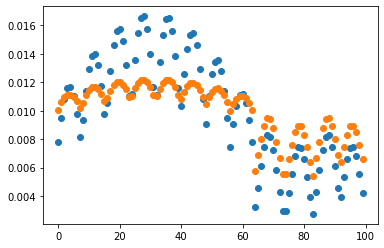

In [310]:
plt.scatter([i for i in range(len(S1))],S1)
plt.scatter([i for i in range(len(S))],S)

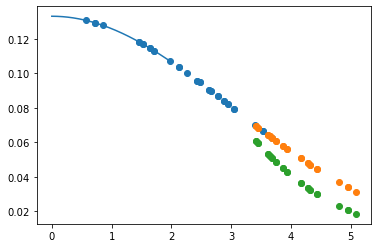

In [246]:
scale_vis(3)

In [272]:
ALL_set = A+B
P = [get_photo(i[0],i[1]) for i in ALL_set]

In [273]:
Bias_all = get_bias([8.4,8.6],ALL_set,-8.3,8.6)
Disparity_matrix = [disparity_matrix(B,240,320) for B in Bias_all]
Re_images = [re_image(P[i],Disparity_matrix[i],320,240) for i in range(len(Bias_all))]

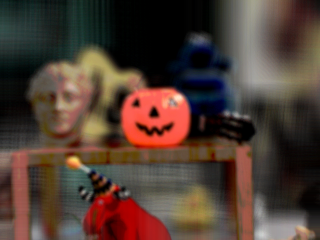

In [333]:
R1 = [img_2_matrix(pp) for pp in Re_images]
C2 = Blend_by_weight(R1,S)
C3 = Blend_by_weight(R1,S1)
C4 = Blend_by_weight(R1,S2*1.11)
Image.fromarray(C4)

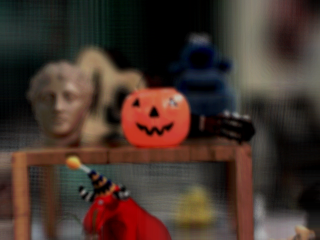

In [308]:
R1 = [img_2_matrix(pp) for pp in Re_images]
C2 = Blend_by_weight(R1,S1)
Image.fromarray(C2)

In [256]:
ALL_set = A+B
P = [get_photo(i[0],i[1]) for i in ALL_set]
Bias_all = get_bias([8.4,8.6],ALL_set,-8.3,8.6)
Disparity_matrix = [disparity_matrix(B,240,320) for B in Bias_all]
Re_images = [re_image(P[i],Disparity_matrix[i],320,240) for i in range(len(Bias_all))]

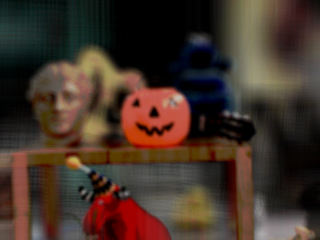

In [311]:
R4 = [img_2_matrix(pp) for pp in Re_images]
C4 = Blend_by_weight(R4,S)
Image.fromarray(C4)

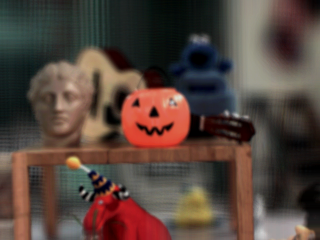

In [260]:
C4 = Blend_by_weight(R4,S)
Image.fromarray(C4)

In [258]:
len(S)

64

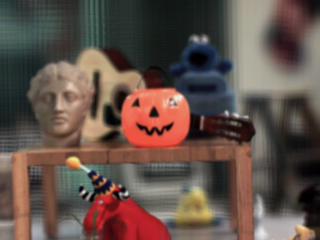

In [210]:
C2 = Blend_by_weight(R1,S)
Image.fromarray(C2)

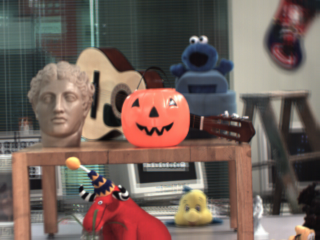

In [191]:
X = Q_interpolator2([8.4,8.6],-8.3,8.6)
im=Image.fromarray(X)
im

In [113]:
Bias_all = get_bias([8.4,8.6],A,-8.3,5.6)
Disparity_matrix = [disparity_matrix(B,240,320) for B in Bias_all]
Re_images = [re_image(P[i],Disparity_matrix[i],320,240) for i in range(len(Bias_all))]

In [132]:
R3 = [img_2_matrix(pp) for pp in Re_images]
S= normalize(Inner_*Weight_inner)
C3 = Blend_by_weight(R,S*1.5)

In [194]:
sum(SS)

array([0.08325964, 0.25012578, 0.27643174, 0.11238876, 0.20478567,
       0.61521016, 0.67991237, 0.27643174, 0.18529774, 0.55666517,
       0.61521016, 0.25012578, 0.06168026, 0.18529774, 0.20478567,
       0.08325964])

In [300]:
def scale_vis(s):
    l = [i*0.01 for i in range(200)]
    plt.plot(l,norm.pdf(l,scale = s*2))
    plt.scatter(Inner_distence,norm.pdf(Inner_distence,scale = s*2))
    plt.scatter(Outer_distence,norm.pdf(Outer_distence,scale = s*2))

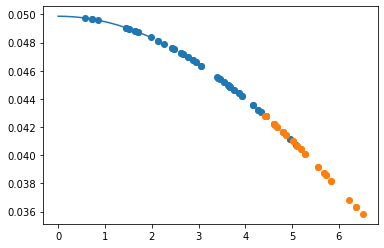

In [301]:
scale_vis(4)